In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../input/us-accidents/US_Accidents_Dec19.csv')

## Accidents count (group by States)

In [3]:
# create df for state accidents
import plotly.graph_objects as go
state_count_acc = pd.value_counts(data['State'])

fig = go.Figure(data=go.Choropleth(
    locations=state_count_acc.index,
    z = state_count_acc.values.astype(float),
    locationmode = 'USA-states',
    colorscale = 'Reds',
    colorbar_title = "Count Accidents",
))

fig.update_layout(
    title_text = '2016 - 2019 US Traffic Accident Dataset by State',
    geo_scope='usa',
)

fig.show()

## County USA ACCidents

For county plots we need install plotly-geo

In [4]:
!pip install plotly-geo

     |████████████████████████████████| 23.7MB 4.5MB/s 


Here I download special dataset to get county codes:

In [5]:
df_county = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/laucnty16.csv')
df_county.head(3)

LAUS Code  State FIPS Code  County FIPS Code  \
0  CN0100100000000                1                 1   
1  CN0100300000000                1                 3   
2  CN0100500000000                1                 5   

  County Name/State Abbreviation  Year  Labor Force     Employed  Unemployed  \
0             Autauga County, AL  2016  25,649       24,297       1,352        
1             Baldwin County, AL  2016  89,931       85,061       4,870        
2             Barbour County, AL  2016   8,302        7,584         718        

   Unemployment Rate (%)  
0                    5.3  
1                    5.4  
2                    8.6

In [6]:
df_county['county_full'] = df_county['County Name/State Abbreviation'].apply(lambda x: x.split(', ')[0])
df_county['county_name'] = df_county['county_full'].apply(lambda x: x.split(' County')[0])

county_count_acc = pd.value_counts(data['County'])
fips_county_df = df_county[['county_name', 'County FIPS Code', 'State FIPS Code']].merge(county_count_acc, left_on='county_name', right_index=True)

In [7]:
import plotly.figure_factory as ff

fips_county_df['State FIPS Code'] = fips_county_df['State FIPS Code'].apply(lambda x: str(x).zfill(2))
fips_county_df['County FIPS Code'] = fips_county_df['County FIPS Code'].apply(lambda x: str(x).zfill(3))
fips_county_df['FIPS'] = fips_county_df['State FIPS Code'] + fips_county_df['County FIPS Code']

colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]
endpts = list(np.linspace(1,30000, len(colorscale) - 1))
fips = fips_county_df['FIPS'].tolist()
values = fips_county_df['County'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
    binning_endpoints=endpts, colorscale=colorscale,
    show_state_data=False,
    show_hover=True,
    asp = 2.9,
    title_text = 'USA County accidents count',
    legend_title = 'Accidents count'
)
fig.layout.template = None
fig.show()

## Severity accidents

Here I sample only 10000 points to save memory.

In [8]:
data_sever = data.sample(n=10000)

fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = data_sever['Start_Lng'],
        lat = data_sever['Start_Lat'],
        text = data_sever['City'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Reds',
            cmin = data_sever['Severity'].max(),
        color = data_sever['Severity'],
        cmax = 1,
            colorbar_title="Severity"
        )))

fig.update_layout(
        title = 'Severity of accidents',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.7,
            subunitwidth = 0.7
        ),
    )
fig.show()

## Severity by county

In [9]:
county_severity_acc = data[['County','Severity']].groupby('County').mean().reset_index()
fips_county_sev = df_county[['county_name', 'County FIPS Code', 'State FIPS Code']].merge(county_severity_acc, left_on='county_name', right_on='County')
fips_county_sev['Severity'] = fips_county_sev['Severity'].apply(lambda x: round(x,1))

In [10]:
fips_county_sev['State FIPS Code'] = fips_county_sev['State FIPS Code'].apply(lambda x: str(x).zfill(2))
fips_county_sev['County FIPS Code'] = fips_county_sev['County FIPS Code'].apply(lambda x: str(x).zfill(3))
fips_county_sev['FIPS'] = fips_county_sev['State FIPS Code'] + fips_county_sev['County FIPS Code']


fips = fips_county_sev['FIPS'].tolist()
values = fips_county_sev['Severity'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['usa'],
#     binning_endpoints=endpts,
#     show_state_data=False,
#     show_hover=True,
#     asp = 2.9,
    title_text = 'USA accidents severity (mean)',
    legend_title = 'Accidents severity'
)
fig.layout.template = None
fig.show()

## Visibility & Severity

In [11]:
data_sever = data.sample(n=10000)[['Start_Lng','Start_Lat','City','Visibility(mi)','Severity']]
data_sever.dropna(inplace=True)

fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = data_sever['Start_Lng'],
        lat = data_sever['Start_Lat'],
        text = data_sever['City'],
        mode = 'markers',
        marker = dict(
            size = data_sever['Visibility(mi)'],
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Blues',
            cmin = data_sever['Severity'].max(),
        color = data_sever['Severity'],
        cmax = 1,
            colorbar_title="Severity"
        )))

fig.update_layout(
        title = 'Severity & Visibility of accidents',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.7,
            subunitwidth = 0.7
        ),
    )
fig.show()

## Distance & Severity

In [12]:
data_sever = data.sample(n=15000)[['Start_Lng','Start_Lat','City','Distance(mi)','Severity']]
data_sever.dropna(inplace=True)

fig = go.Figure(data=go.Scattergeo(
        locationmode = 'USA-states',
        lon = data_sever['Start_Lng'],
        lat = data_sever['Start_Lat'],
        text = data_sever['City'],
        mode = 'markers',
        marker = dict(
            size = data_sever['Distance(mi)'],
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'circle',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = 'Viridis',
            cmin = data_sever['Severity'].max(),
        color = data_sever['Severity'],
        cmax = 1,
            colorbar_title="Severity"
        )))

fig.update_layout(
        title = 'Severity & Distance of accidents',
        geo = dict(
            scope='usa',
            projection_type='albers usa',
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.7,
            subunitwidth = 0.7
        ),
    )
fig.show()

## Classification accidents severity by text description

Let's do something strange and try to predict accident severity by it's text description :)

In [13]:
from more_itertools import sliced
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks.callbacks import EarlyStopping

Using TensorFlow backend.


In [14]:
text_data = data[['Description','Severity']].sample(n=1000, random_state=10)
text_data.head()

Description  Severity
2355736                At I-280/OH-420/Exit 71 - Accident.         2
1755961  Accident on I-476 Southbound from Exit 44 to E...         3
1695530  Right hand shoulder blocked due to accident on...         3
1608215     Accident on Memorial Hwy at Independence Pkwy.         2
1774276  Accident on I-805 Southbound at Exit 21 CA-274...         3

In [15]:
for i in range(15):
    print(text_data['Description'].iloc[i])

At I-280/OH-420/Exit 71 - Accident.
Accident on I-476 Southbound from Exit 44 to Exits 31 31A 31B PA-63 Sumneytown Pike.
Right hand shoulder blocked due to accident on I-295 Southbound before Exit 51 US-90 Beach Blvd.
Accident on Memorial Hwy at Independence Pkwy.
Accident on I-805 Southbound at Exit 21 CA-274 Balboa Ave.
Accident on SC-215 Blackstock Rd at Cinder Ridge Dr.
At CR-613/Flanders Netcong Rd - Accident.
Accident on Penn Ave at I-240 Service Rd.
Accident a motorcycle involved on Haverhill St at Rustic Ln.
Accident on Greenbriar Rd at Southwest Pkwy.
Accident on I-264 Eastbound at Exits 11 12 I-65.
At I-80/Exit 304 - Accident.
Restrictions due to accident and fallen power cables on 76th St at Parkview Blvd.
Accident on I-77 Southbound at Brookshire Fwy.
Multi-vehicle accident on I-90 Westbound at Exit 188 I-271.


In [16]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 100
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(text_data['Description'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1822 unique tokens.


In [17]:
X = tokenizer.texts_to_sequences(text_data['Description'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pd.get_dummies(text_data['Severity']).values
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (1000, 500)
Shape of label tensor: (1000, 3)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(900, 500) (900, 3)
(100, 500) (100, 3)


In [19]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# choose epochs and batch_size
epochs = 15
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)])

/opt/conda/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Train on 810 samples, validate on 90 samples
Epoch 1/15
810/810 [==============================] - 10s 13ms/step - loss: 0.9236 - accuracy: 0.6531 - val_loss: 0.8811 - val_accuracy: 0.6000
Epoch 2/15
810/810 [==============================] - 9s 11ms/step - loss: 0.7067 - accuracy: 0.6815 - val_loss: 0.8003 - val_accuracy: 0.6000
Epoch 3/15
810/810 [==============================] - 9s 11ms/step - loss: 0.5998 - accuracy: 0.7358 - val_loss: 0.6605 - val_accuracy: 0.7222
Epoch 4/15
810/810 [==============================] - 9s 11ms/step - loss: 0.5087 - accuracy: 0.7852 - val_loss: 0.6268 - val_accuracy: 0.7889
Epoch 5/15
810/810 [==============================] - 9s 11ms/step - loss: 0.4283 - accuracy: 0.8481 - val_loss: 0.5204 - val_accuracy: 0.8000
Epoch 6/15
810/810 [==============================] - 9s 11ms/step - loss: 0.3581 - accuracy: 0.8716 - val_loss: 0.4503 - val_accuracy: 0.8444
Epoch 7/15
810/810 [==============================] - 9s 11ms/step - loss: 0.3090 - accuracy: 0.

In [20]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

100/100 [==============================] - 0s 3ms/step
Test set
  Loss: 0.250
  Accuracy: 0.910


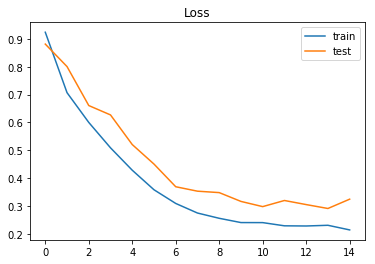

In [21]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

### If you like this kernel, upvote it please.